In [1]:
suppressMessages(library(rwwa))


# function to fill infinite probability ratios
infer_infinite <- function(models_in) {
    
    # split out the columns for easier reference
    est <- est_n <- models_in[,1]
    l <- l_n <- models_in[,2]
    u <- u_n <- models_in[,3]
    
    # relabel where infinite best estimate / upper bound occurs
    mnames <- rownames(models_in)
    mnames <- paste0(mnames, c("*","")[is.finite(est)+1])
    mnames <- paste0(mnames, c("*","")[is.finite(u)+1])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE BEST ESTIMATES / UPPER BOUNDS
    # get upper bound where best estimate is infinite
    u_n[!is.finite(u_n)] <- (exp(log(est) + 3 * (log(est) - log(l))))[!is.finite(u_n)]

    # get best estimate, if infinite
    if(any(is.finite(u))) {
        # if any estimated upper bounds are finite, use the maximum upper bound to infer infinite best estimates
        f_upper <- max(u[is.finite(u)])
    } else {
        # otherwise, use the maximum inferred upper bound to infer infinite best estimates
        f_upper <- max(u_n[is.finite(u_n)])
    }
    est_n[!is.finite(est_n)] <- f_upper

    # repeat estimation of upper bound using inferred best estimate
    u_n[!is.finite(u_n)] <- (exp(log(est_n) + 3 * (log(est_n) - log(l))))[!is.finite(u_n)]
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # INFINITE LOWER BOUNDS NOT YET IMPLEMENTED

    return(data.frame("est" = est_n, "lower" = l_n, "upper" = u_n, row.names = mnames))   
}

In [2]:
nsamp <- 1000
rp <- 100

In [30]:
fl <- list.files("cmip6", pattern = "Tx7day.+csv", full.names = T)
for (fnm in fl) {
    
    mdl <- paste0(gsub(".dat", "", strsplit(fnm, "_")[[1]][c(4,6)]), collapse = "_")
    print(mdl)
    
    gmst_fnm <- list.files("cmip6", pattern = paste0("SGSAT2025.",mdl), full.names = T)
    if(length(gmst_fnm) != 1) {
        print("No GMST")
        next
    }

    res_fnm <- gsub("cmip6", "cmip6-res", gsub(".dat", ".csv", fnm))
    
    df <- merge(load_ts(gmst_fnm, col.names = c("year", "gmst")), 
                read.csv(fnm, col.names = c("year", "tx7x")))
    
    mdl <- fit_ns(dist = "gev", type = "shift", data = df, varnm = "tx7x", covnm = "gmst", lower = F)
    
    # use model's 2025 GMST to define factual climate        
    cov_now <- df[df$year == 2025,"gmst",drop = F]
    cov_hist <- cov_now - 1.3
    cov_fut <- cov_now + 1.3

    # bootstrap results
    res <- cmodel_results(mdl, rp = rp, cov_f = cov_now, cov_hist = cov_hist, cov_fut = cov_fut,
                          y_now = 2025, y_start = 1940, y_fut = 2070, nsamp = nsamp)
    res <- cbind(res, data.frame("ystart" = min(df$year), "yend" = max(df$year)))
    write.csv(res, res_fnm)

    # quick return level plots to check fit
    rlplot_fnm <- gsub("csv", "png", gsub("res/", "fig/rlplot_", res_fnm))
    if(!file.exists(rlplot_fnm)) {
        png(rlplot_fnm, h = 360, w = 480); par(cex.main = 1.4); {
            plot_returnlevels(mdl, cov_f = cov_now, cov_cf = cov_hist, nsamp = 100, main = gsub("ts/", "", gsub(".csv", "", fnm)))
        }; dev.off()
    }
}

[1] "ACCESS-CM2_r1i1p1f1"
[1] "ACCESS-ESM1-5_r1i1p1f1"
[1] "CanESM5_r1i1p1f1"
[1] "CMCC-ESM2_r1i1p1f1"
[1] "CNRM-CM6-1_r1i1p1f2"
[1] "CNRM-CM6-1-HR_r1i1p1f2"
[1] "EC-Earth3_r1i1p1f1"
[1] "EC-Earth3-Veg_r1i1p1f1"
[1] "EC-Earth3-Veg-LR_r1i1p1f1"
[1] "FGOALS-g3_r1i1p1f1"
[1] "INM-CM4-8_r1i1p1f1"
[1] "INM-CM5-0_r1i1p1f1"
[1] "IPSL-CM6A-LR_r1i1p1f1"
[1] "MIROC6_r1i1p1f1"
[1] "MPI-ESM1-2-HR_r1i1p1f1"
[1] "MPI-ESM1-2-LR_r1i1p1f1"
[1] "MRI-ESM2-0_r1i1p1f1"
[1] "NorESM2-MM_r1i1p1f1"


In [31]:
# compile results
res <- t(sapply(list.files("cmip6-res", full.names = T), read.csv, row.names = "X"))
rownames(res) <- apply(sapply(strsplit(gsub(".csv", "", rownames(res)), "_"), "[", 4:5), 2, paste0, collapse = "_")
write.csv(res, paste0("res-models_tx7x_cmip6.csv"))

# Synthesis

In [67]:
expand_uw <- function(synth) {
    return(rbind(synth$df, data.frame(group = "synth_uw", model = "Unweighted", est = synth$uw_mean, lower = synth$df[synth$df$model == "Synthesis", "l_wb"], upper = synth$df[synth$df$model == "Synthesis", "u_wb"], l_wb = NA, u_wb = NA)))
}

In [67]:
obs <- read.csv("obs-res.csv", row.names = "X")

highresmip <- read.csv("model-res.csv", row.names = "Models")
models <- models[models$include == "Y",]

# remove 0 or infinite lower boumds
models <- models[rowSums(models == 0) == 0,]
models <- models[rowSums(!is.finite(as.matrix(models[,grepl("lower", colnames(models))]))) == 0,]

In [68]:
synth_di_attr <- synthesis(obs_in = obs[,grepl("DI", colnames(obs))], models_in = models[,grepl("DI_attr", colnames(models))], synth_type = "abs")
synth_di_proj <- synthesis(obs_in = NA, models_in = models[,grepl("DI_proj", colnames(models))], synth_type = "abs")
synth_di_proj2 <- synthesis(obs_in = obs[,grepl("DI", colnames(obs))], models_in = models[,grepl("DI_proj", colnames(models))], synth_type = "abs")

In [118]:
write.csv(expand_uw(synth_di_attr), "synth_di_attr.csv", row.names = F)
write.csv(synth_di_proj$df, "synth_di_proj.csv", row.names = F)
write.csv(expand_uw(synth_di_proj2), "synth_di_proj-with-obs.csv", row.names = F)

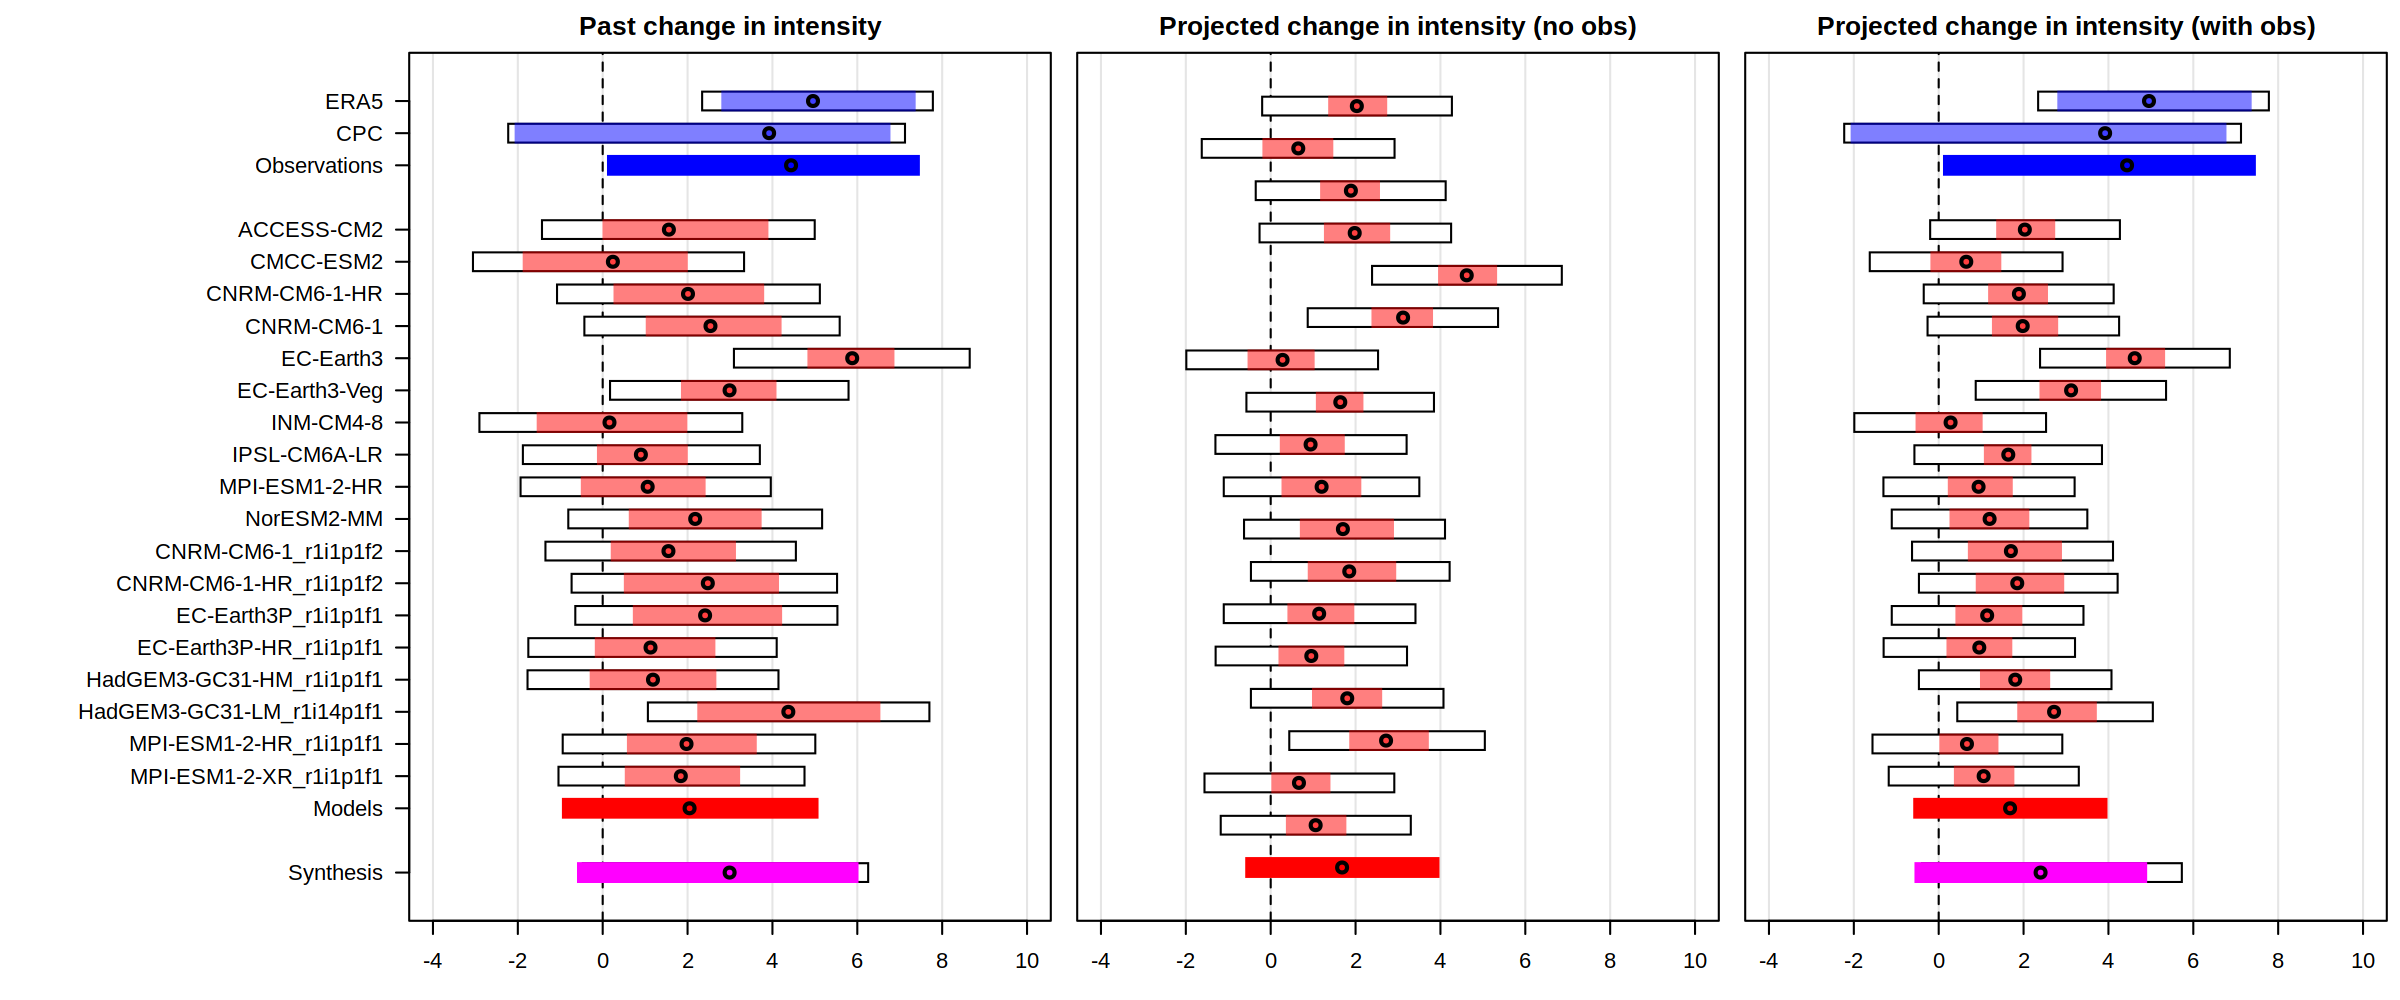

In [69]:
prep_window(c(1,3), oma = c(0,15,0,0), mar = c(3,0.5,2,0.5), h = 5)

xlim <- c(-4,10)
plot_synthesis(synth_di_attr, xlim = xlim, xlab = "Change in intensity (degC)", main = "Past change in intensity")
plot_synthesis(synth_di_proj, hide_labels = T, xlim = xlim, xlab = "Change in intensity (degC)", main = "Projected change in intensity (no obs)")
plot_synthesis(synth_di_proj2, hide_labels = T, xlim = xlim, xlab = "Change in intensity (degC)", main = "Projected change in intensity (with obs)")

In [90]:
synth_pr_attr <- synthesis(obs_in = infer_infinite(obs[,grepl("PR", colnames(obs))]), models_in = infer_infinite(models[,grepl("PR_attr", colnames(models))]), synth_type = "PR")
synth_pr_proj <- synthesis(obs_in = NA, models_in = infer_infinite(models[,grepl("PR_proj", colnames(models))]), synth_type = "PR")
synth_pr_proj2 <- synthesis(obs_in = infer_infinite(obs[,grepl("PR", colnames(obs))]), models_in = infer_infinite(models[,grepl("PR_proj", colnames(models))]), synth_type = "PR")

In [90]:
write.csv(expand_uw(synth_pr_attr), "synth_pr_attr.csv", row.names = F)
write.csv(synth_pr_proj$df, "synth_pr_proj.csv", row.names = F)
write.csv(expand_uw(synth_pr_proj2), "synth_pr_proj-with-obs.csv", row.names = F)

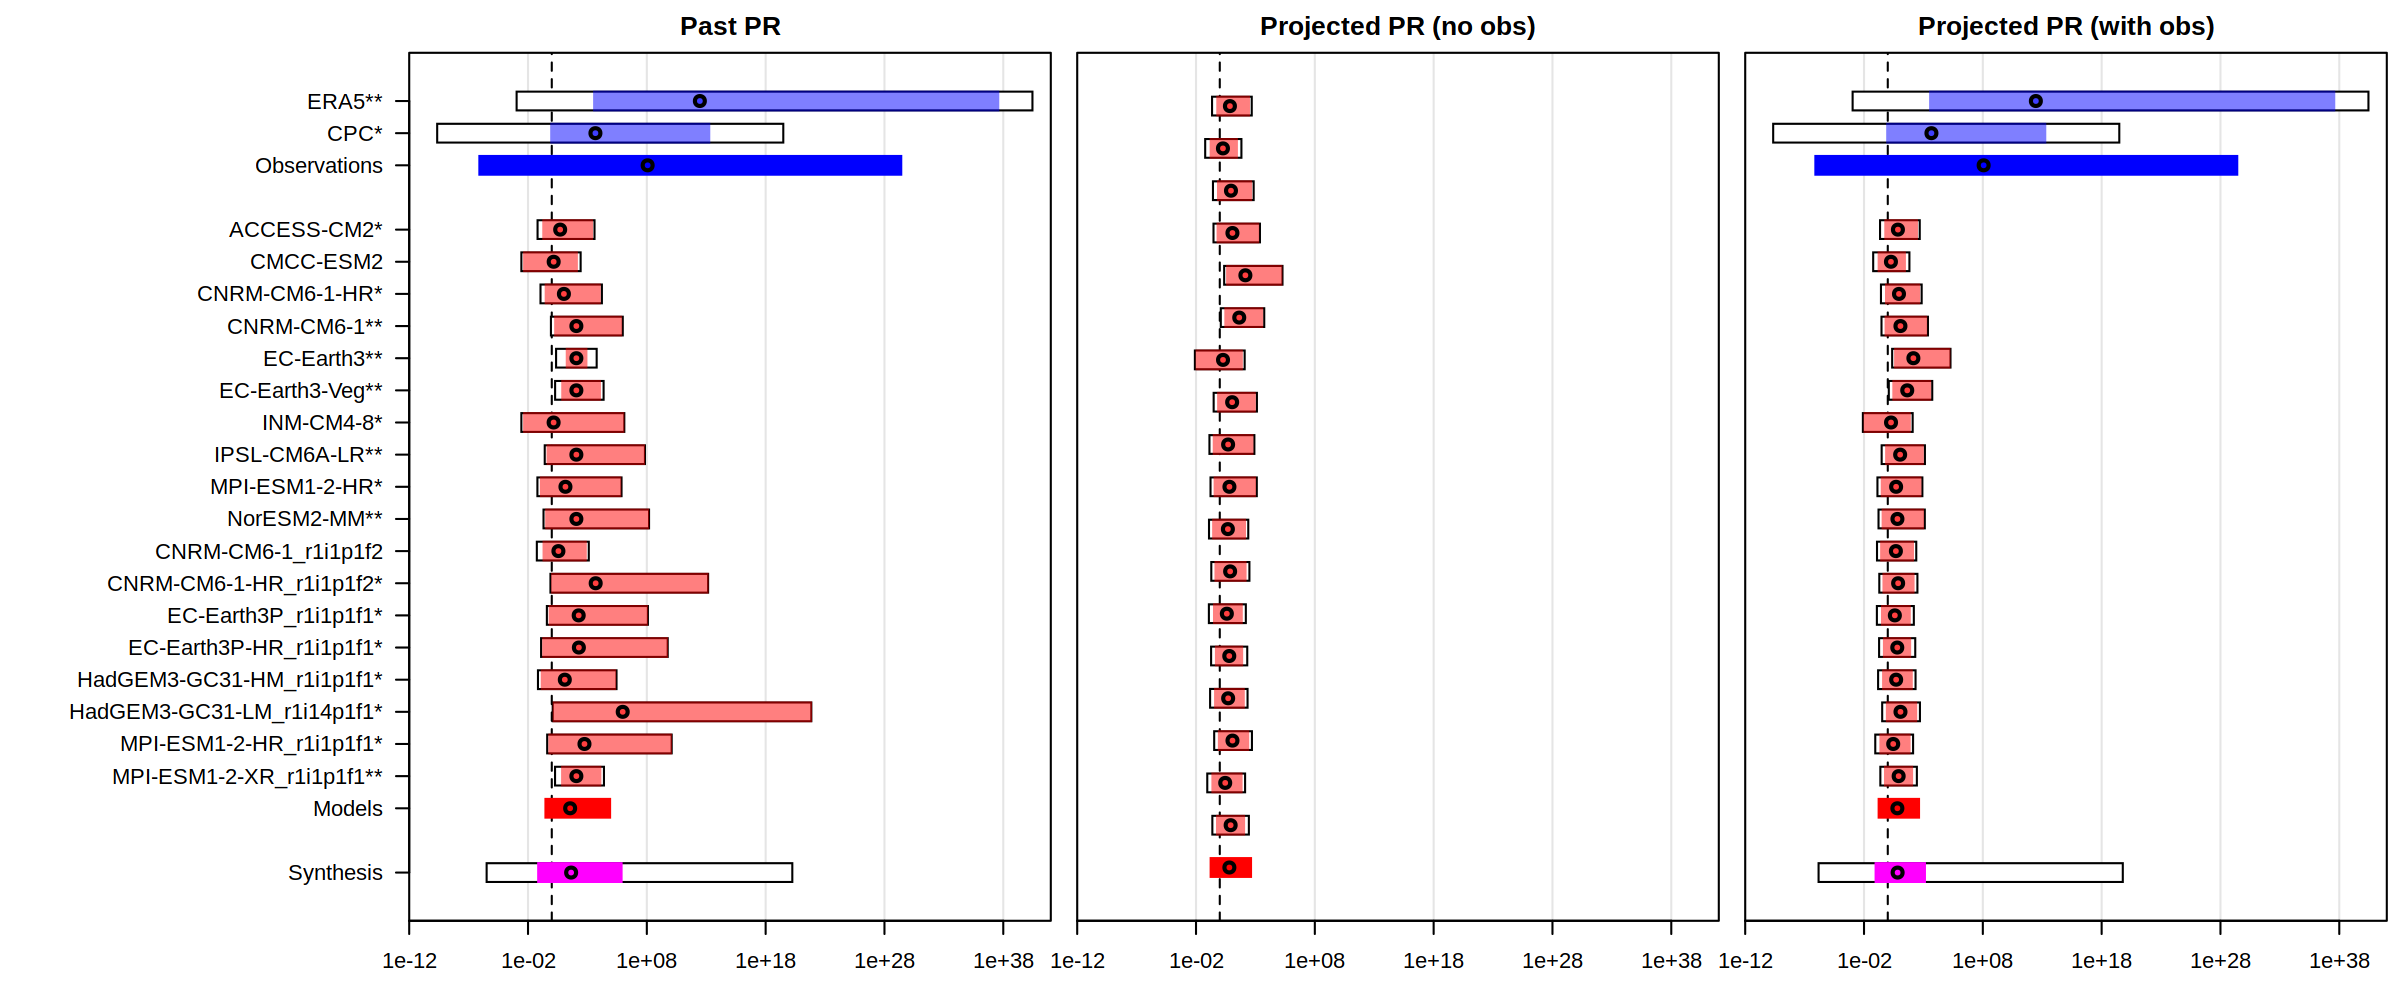

In [94]:
prep_window(c(1,3), oma = c(0,15,0,0), mar = c(3,0.5,2,0.5), h = 5)

xlim = c(1e-10, 1e+40)
plot_synthesis(synth_pr_attr, xlab = "Probability ratio", main = "Past PR", xlim = xlim)
plot_synthesis(synth_pr_proj, hide_labels = T, xlab = "Probability ratio", main = "Projected PR (no obs)", xlim = xlim)
plot_synthesis(synth_pr_proj2, hide_labels = T, xlab = "Probability ratio", main = "Projected PR (with obs)", xlim = xlim)


[1] -0.2485467